In [39]:
# The Ising model is a simple model for ferromagnetism. Atoms with spin
# S ∈ {−1, 1} are given fixed locations and their spin interactions are limited
# to nearest neighbours. The total energy (Hamiltonian) of the system is therefore

# H = -sum_<i,j> (S_iS_j)

# where <i,j> denotes neighbouring sites such that each interaction is only
# counted once.
# In two dimensions, the simplest Ising model looks like

# s11 s21 s31 s41
# s12 s22 s32 s42
# s13 s23 s33 s43
# s14 s24 s34 s44

# where, for instance, the neighbours of s22 are s21, s12, s32, s23.

# Make a function that takes an N × N matrix S and calculates H
# assuming a periodic system.

# a
import numpy as np
from numba import njit, jit

@njit
def calculate_H(S):
    N = len(S)
    H = 0
    
    for i in range(N):
        for j in range(N):
            neighbor_sum = (
                S[i][(j + 1 ) % N] +  # right
                S[i][(j - 1 ) % N] +  # left
                S[(i + 1 ) % N][j] +  # bottom
                S[(i - 1 ) % N][j]  # top
            )
            H += -S[i][j] * neighbor_sum
    
    return H

S = 2*np.random.randint(0, 2, (4,4))-1

print(S)

H = calculate_H(S)
print("H:", H)


[[ 1 -1  1 -1]
 [-1 -1  1  1]
 [ 1  1  1  1]
 [ 1 -1 -1  1]]
H: 0


In [40]:
# In the lowest possible energy state all spins are aligned, i.e. they all equal
# 1 or −1, which corresponds to full magnetisation. However, fluctuations
# at finite temperatures will drive the system away from this minimum.
# The likelihood of a given spin configuration is given by the Boltzmann
# distribution

# p(S) = (e^(-H/T))/Z

# where T is the temperature and Z is the partition function. The magneti-
# sation of a specific spin configuration is simply

# m(S) = <S_i>

# Make a function that calculates the magnetisation.

# b
@njit
def calculate_magnetization(S):
    return np.mean(S)

magnetization = calculate_magnetization(S)
print("Magnetization: ",magnetization)

Magnetization:  0.25


In [41]:
# We shall be interested in the time-averaged magnetisation as a function
# temperature T. We will use the Metropolis–Hastings algorithm to simulate
# the time evolution of the system.

# Make a function that calculates the change in energy ΔE from a
# spin flip at a given location i.

# c
@njit
def calculate_delta_energy(S, i, j):
    N = len(S)
    neighbor_sum = (
        S[i, (j + 1) % N]
        + S[(i + 1) % N, j]
        + S[i, (j - 1) % N]
        + S[(i - 1) % N, j]
    )
    delta_energy = 2 * S[i, j] * neighbor_sum
    return delta_energy

i = 2
j = 2

de = calculate_delta_energy(S,i,j)

print("Change in energy:", de)


Change in energy: 4


In [42]:
# Make a function that randomly accepts or rejects a spin flip based
# on ΔE with probability a = min(1, e^(−ΔE/T)).

# d
@njit
def accept_spin_flip(de, temperature):
    prob_a = min(1, np.exp(-de / temperature))
    rnd = np.random.rand()
    return np.random.rand() < prob_a

de = 5
temperature = 5


if accept_spin_flip(de,temperature):
    print("Accepted")
else:
    print("Rejected")


Accepted


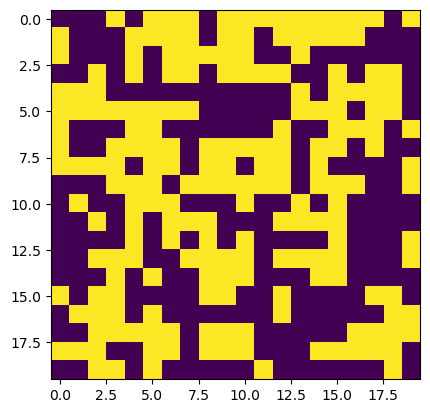

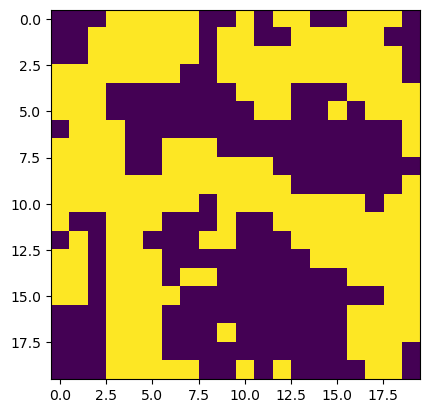

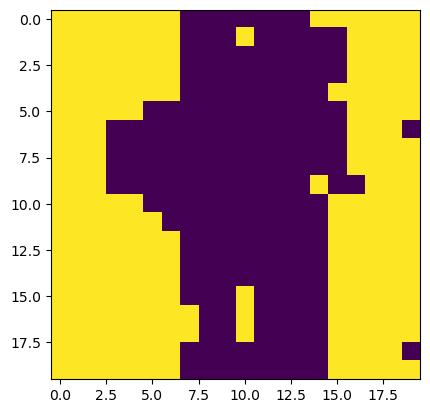

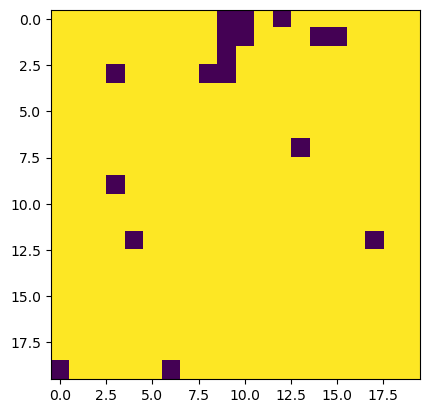

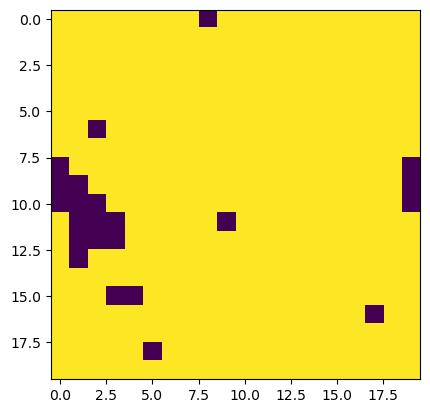

KeyboardInterrupt: 

In [51]:
# To take a Metropolis–Hastings step, a random random spin is chosen
# and flipped according to the above rule.

# Start with a random initialisation of S with N ≥ 5 depending on
# the speed of your code (N = 1000 should be possible with numba). Let
# the system run for 1000 N^2 time steps to equilibrium the system. Plot the
# spin configuration (plt.imshow with interpolation=’nearest’) at
# different times during the simulation. Comment on the result.

# e
import numpy as np
import matplotlib.pyplot as plt
size = 20

#@njit
def simulate_ising_model(N, temperature):
    #im_array = np.zeros(4)
    #index = 0
    S = 2*np.random.randint(0, 2, (size,size))-1

    equilibrium_steps = 1000 * N**2

    for step in range(equilibrium_steps):
        i, j = np.random.randint(size), np.random.randint(size)

        delta_energy = calculate_delta_energy(S, i, j)
        if accept_spin_flip(delta_energy, temperature):
            S[i, j] *= -1

        if step==equilibrium_steps/100000 or step == equilibrium_steps/5000 or step == equilibrium_steps/500 or step == equilibrium_steps/100 or step == equilibrium_steps/10:#step % (equilibrium_steps / 4) == 0:
            plt.imshow(S, interpolation='nearest')
            plt.show()
            #im_array[index] = S
            #index+=1

    #return im_array

temperature = 2.0
N = 100

simulate_ising_model(N,temperature)




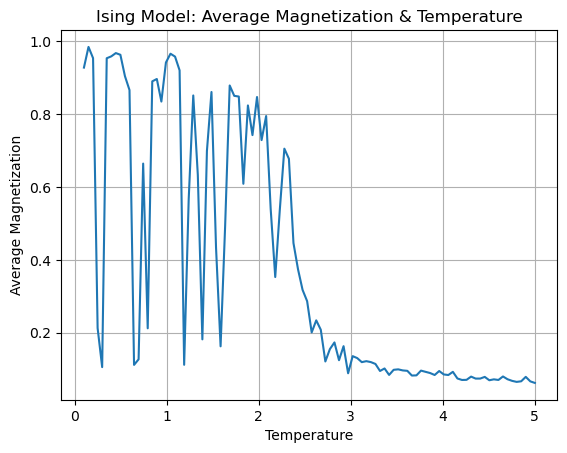

In [ ]:
# After initialisation let the system evolve another 1000 N^2 time
# steps, and store at each 100th time step the energy and the mag-
# netisation. Do this for temperatures between 0.1 and 5.0 (e.g.
# np.linspace(0.1, 5.0, 100)) and plot the average absolute mag-
# netisation as a function of temperature.

# f
import numpy as np
import matplotlib.pyplot as plt
size = 20

#@njit
def simulate_ising_model(N, temperature):
    
    S = 2*np.random.randint(0, 2, (size,size))-1
    energy_data = []
    magnetization_data = []

    equilibrium_steps = 1000 * N**2

    for step in range(equilibrium_steps):
        i, j = np.random.randint(size), np.random.randint(size)

        delta_energy = calculate_delta_energy(S, i, j)
        if accept_spin_flip(delta_energy, temperature):
            S[i, j] *= -1

        if step % 100 == 0:
            energy_data.append(calculate_H(S)) #måske calculate_H
            magnetization_data.append(calculate_magnetization(S))

    return energy_data, magnetization_data

temperatures = np.linspace(0.1, 5.0, 100)
average_magnetizations = []

N = 10

for temperature in temperatures:
    energy_data, magnetization_data = simulate_ising_model(N, temperature)
    average_magnetizations.append(np.mean(np.abs(magnetization_data)))

plt.plot(temperatures, average_magnetizations)
plt.xlabel('Temperature')
plt.ylabel('Average Magnetization')
plt.title('Ising Model: Average Magnetization & Temperature')
plt.grid(True)
plt.show()


In [ ]:
# You should find that the system spontaneously magnetises at low temper-
# ature. In particular, there is a phase transition at a critical temperature T_c
# below which the material is ferromagnetic.

# Determine T_c as best you can. What ways could you improve your
# estimate?

# g


